## Code Overview
This code is divided into three sections:
  1. Data Preprocessing
  2. Model Implementation
  3. Evaluation

In [ ]:
# Install required libraries
!pip install googletrans==3.1.0a0
!pip install tensorflow

In [ ]:
!pip install nltk
!pip install matplotlib

## Section 1: Data Preprocessing


In [ ]:
import os
#import googletrans
#from googletrans import Translator
import string
import nltk
from nltk.translate.bleu_score import corpus_bleu
import pickle
from pickle import dump
from pickle import load
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Load data from drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Paths & Params
# Change your paths acc. to your directory
PATH = '/content/drive/MyDrive/NEP_CAP/Flickr8k_Dataset/test/'
CAP_PATH = '/content/drive/MyDrive/NEP_CAP/Flickr8k_Dataset/translated_nepali_captions.txt'
IMG_PATH = '/content/drive/MyDrive/NEP_CAP/Flickr8k_Dataset/flickr8k_images/'
IMG_SIZE = (299,299)

MODEL_PATH = '/content/drive/MyDrive/NEP_CAP/models_flickr8k/model.hd5'
VEC_PATH = '/content/drive/MyDrive/NEP_CAP/models_flickr8k/text_vector.pkl'
#CHECKPOINT_PATH = '/content/drive/MyDrive/NEP_CAP/models_flickr8k/checkpoint.hd5'

VOCAB_SIZE = 15000 # change acc. to number of words in your dataset
SEQ_LENGTH = 20
EMBED_DIM = 512

NUM_HEADS = 2
FF_DIM = 512

BATCH_SIZE = 128
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load caption data
def load_captions(filepath):
    file = open(filepath,'r',encoding='utf-8')
    captions_text = file.read()
    file.close()
    return captions_text


In [ ]:
#Load caption description
def load_captions_description(caption_text):
    # dict  to map image name (keys) with caption list(values)
    caption_mapping = {}
    text_data = []

    for line in caption_text.split('\n'):
        #split line by white space
        tokens = line.split()

        #assigning image id and caption from tokens
        image_id, caption = tokens[0], tokens[1:]

        #extract filename from image id
        image_name = image_id.split('#')[0]
        image_name = os.path.join(IMG_PATH,image_name.strip())

        if image_name.endswith("jpg"):
            caption = ' '.join(caption)
            caption = caption.strip()
            text_data.append(caption)

            if image_name in caption_mapping:
                caption_mapping[image_name].append(caption)
            else:
                caption_mapping[image_name] = [caption]

    return caption_mapping,text_data

In [ ]:
load_data = load_captions(CAP_PATH)
#print(load_data)
c_m,t_d = load_captions_description(load_data)


In [ ]:
#Data Cleaning

In [ ]:
#Removing punctuation (using translation table) and special characters
def data_clean(cap_map):
    txt_data = []
    punctuation_table = str.maketrans('','',string.punctuation)
    for key, captions_list in cap_map.items():
        for i in range(len(captions_list)):
            caption = captions_list[i]
            # tokenize
            caption = caption.split()
            # convert to lower case (for any english word)
            caption = [word.lower() for word in caption]

            # remove punctuation/special cahracters (!@#$%^&* etc.)
            caption = [w.translate(punctuation_table) for w in caption]
            caption = [re.sub(u'[\u0964]+', '', w) for w in caption]
            caption = [re.sub(u'[\u0951]+', '', w) for w in caption]

            # remove tokens with numbers (eng and nepali)
            #caption = [word for word in caption if word.isalpha()]
            caption = [re.sub(r'[0-9]', '', word) for word in caption]
            caption = [re.sub(u'[\u0966-\u096F]+', '', word) for word in caption]

            # store as string
            #captions_list[i] = ' '.join(caption)
            captions_list[i] = 'start ' + ' '.join(caption) + ' end'
            txt_data.append('start ' + ' '.join(caption) + ' end')
    return cap_map, txt_data

In [ ]:
# get data
def get_data(cap_map,PATH):
    cap_mapping = {}
    with open(PATH,'r') as data:
        contents = data.readlines()
        count = 0
        for line in contents:
            line = line.replace('\n','')
            img = IMG_PATH + str(line)
            #print(img)
            value = cap_map[img]
            cap_mapping[img] = value
    return cap_mapping


In [ ]:
# Split train and validation set
def train_validation_split(caption_map, train_size = 0.8, shuffle=True):
    # get list of total images
    total_images = list(caption_map.keys())
    #print(total_images[:6])
    np.random.shuffle(total_images)
    # splitting into train and test set
    train_size = int(len(caption_map)*train_size)

    # open file in write mode
    #Train
    with open(PATH + "train_images.txt", 'w', encoding='utf-8') as fp:
        for image in total_images[:train_size]:
        # write each item on a new line
          fp.write("%s\n" % image)
    # valid and test
    count = 0
    valid_data = open(PATH + "validation_images.txt",'w', encoding='utf-8')
    test_data = open(PATH + "test_images.txt",'w', encoding='utf-8')
    for img in total_images[train_size:]:
        count+=1
        if count<=1000:
            valid_data.write("%s\n" % img)
        else:
            test_data.write("%s\n" % img)

  '''Note: train_images.txt, validation_images.txt, and test_images.txt contains a single image id in each row
     You can split the whole data into three .txt files with only image id in each row for consistency of data
  '''


In [ ]:
load_data = load_captions(CAP_PATH)
c_m,t_d = load_captions_description(load_data)
cap_map, txt_data = data_clean(c_m)
train_validation_split(cap_map)

We'll use the TextVectorization to vectorize the text data to turn the
original strings into integer sequences where each integer represents the index of
a word in a vocabulary.

In [ ]:
# Text Vectorization

def text_vectorization(txt_data):

    vectorization = TextVectorization(
        max_tokens= VOCAB_SIZE,
        output_mode= "int",
        output_sequence_length= SEQ_LENGTH
        )
    vectorization.adapt(txt_data)

    return vectorization

In [ ]:
# save and load vectorization
def save_vectorization(vectorization):
    # Pickle the config and weights
    pickle.dump({'config': vectorization.get_config(),
             'weights': vectorization.get_weights()}
            , open(VEC_PATH, "wb"))

def load_vectorization():
    from_disk = pickle.load(open(VEC_PATH, "rb"))
    vectorization = TextVectorization.from_config(from_disk['config'])
    # You have to call `adapt` with some dummy data (BUG in Keras)
    #new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
    vectorization.set_weights(from_disk['weights'])
    return vectorization


### Dataset Genaration Function

In [ ]:
# create dataset
def img_data(img_path, size=IMG_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img,IMG_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

def create_dataset(img_list, cap_list, txt_vectorization):

    img_dataset = tf.data.Dataset.from_tensor_slices(img_list).map(
        img_data, num_parallel_calls=AUTOTUNE
        )
    caption_dataset = tf.data.Dataset.from_tensor_slices(cap_list).map(
        txt_vectorization, num_parallel_calls=AUTOTUNE
        )

    dataset = tf.data.Dataset.zip((img_dataset,caption_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)


    return dataset

## Section 2: Model Implementation

In [ ]:
# MODEL DESIGN

In [ ]:
# CNN
def cnn_model():
    #model_type = 'resnet'
    model_type = 'efficient'
    if model_type == 'resnet':
        base_model = tf.keras.applications.resnet.ResNet101(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE,3)
        )
    if model_type == 'efficient':
        base_model = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(*IMG_SIZE,3)
        )

    # freeze model
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1,1280))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)

    return cnn_model


In [ ]:
# Transformer Encoder Block
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = layers.Dense(embed_dim, activation="relu")
        self.layernorm_1 = layers.LayerNormalization()

    def call(self, inputs, training, mask=None):
        inputs = self.dense_proj(inputs)
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs,
            attention_mask=None)
        proj_input = self.layernorm_1(inputs + attention_output)

        return proj_input

# Positional Embedding
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs,0)


# Transformer decoder block
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs ):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim= EMBED_DIM, sequence_length = SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE)
        self.droupout_1 = layers.Dropout(0.1)
        self.droupout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.causal_attention_mask(inputs)
        inputs = self.droupout_1(inputs, training=training)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=combined_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        proj_out = self.layernorm_3(out_2 + proj_output)
        proj_out = self.droupout_2(proj_out, training=training)

        preds = self.out(proj_out)
        return preds

    # Causal attention  mask
    def causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i>=j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1,1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)



In [ ]:
# Image captioning model
class ImageCaptioningModel(keras.Model):
    def __init__(self, cnn_model, encoder, decoder, num_caps_per_image=5):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_caps_per_image = num_caps_per_image

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss)/tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_loss_and_acc(self, batch_data, training=True):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # Pass each of the 5 captions to the decoder in the one by one fashion
        # For each caption compute loss and accuracy along with encoder output
        for i in range(self.num_caps_per_image):
            with tf.GradientTape() as tape:
                # pass image embeddings to encoder
                encoder_out = self.encoder(img_embed, training=training)

                batch_seq_inp = batch_seq[:, i, :-1]
                batch_seq_true = batch_seq[:, i, 1:]

                # compute the mask for input sequence
                mask = tf.math.not_equal(batch_seq_inp, 0)

                # Pass the encoder outputs, sequence inputs along with
                # mask to the decoder
                batch_seq_pred = self.decoder(
                    batch_seq_inp, encoder_out, training=training, mask=mask
                )
                # calculate loss and accuracy
                loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
                acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

                # update batch loss and batch accuracy
                batch_loss += loss
                batch_acc += acc

            # Get list of all trainable weights
            train_vars = (self.encoder.trainable_variables + self.decoder.trainable_variables)
            # Get the gradients
            grads = tape.gradient(loss, train_vars)

            # update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        return batch_loss, batch_acc / float(self.num_caps_per_image)

    def train_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(),"acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data, training=False)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]




In [ ]:
# Initialize model
cnn_model = cnn_model()
encoder = TransformerEncoder(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=NUM_HEADS)
decoder = TransformerDecoder(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=NUM_HEADS)
caption_model = ImageCaptioningModel(
        cnn_model=cnn_model, encoder=encoder, decoder=decoder
    )

In [ ]:
load_data = load_captions(CAP_PATH)
c_m,t_d = load_captions_description(load_data)
cap_map, txt_data = data_clean(c_m)
train_data = get_data(cap_map,PATH+'train_images.txt')
valid_data = get_data(cap_map,PATH+'validation_images.txt')
test_data = get_data(cap_map,PATH+'test_images.txt')
print(len(train_data))
print(len(valid_data))
print(len(test_data))

6000
1000
1000


In [ ]:
# Dont run while loading existing model
vectorization = text_vectorization(txt_data)
# save vocab vectors
save_vectorization(vectorization)

txt_vocab = vectorization.get_vocabulary()

In [ ]:
# load text vectors
vectorization = load_vectorization()
txt_vocab = vectorization.get_vocabulary()

In [ ]:
train_dataset = create_dataset(list(train_data.keys()),list(train_data.values()),vectorization)
valid_dataset = create_dataset(list(valid_data.keys()),list(valid_data.values()),vectorization)
print(train_dataset)
print(valid_dataset)
print(len(txt_vocab))

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 20), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 20), dtype=tf.int64, name=None))>
14077


In [ ]:
# define loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

# early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)
# checkpoint
#checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, save_best_only=True)

# compile model
caption_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=cross_entropy)


In [ ]:
# fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset
    #callbacks=[early_stopping]
    )

# save model
caption_model.save_weights(MODEL_PATH)


Epoch 1/30
47/47 [==============================] - 41s 546ms/step - loss: 30.0482 - acc: 0.1755 - val_loss: 24.6387 - val_acc: 0.2969
Epoch 2/30
47/47 [==============================] - 23s 423ms/step - loss: 22.5764 - acc: 0.3197 - val_loss: 20.8734 - val_acc: 0.3546
Epoch 3/30
47/47 [==============================] - 23s 420ms/step - loss: 20.0949 - acc: 0.3642 - val_loss: 18.8229 - val_acc: 0.3855
Epoch 4/30
47/47 [==============================] - 23s 421ms/step - loss: 18.5452 - acc: 0.3903 - val_loss: 17.4134 - val_acc: 0.4052
Epoch 5/30
47/47 [==============================] - 23s 419ms/step - loss: 17.4168 - acc: 0.4093 - val_loss: 16.3073 - val_acc: 0.4247
Epoch 6/30
47/47 [==============================] - 23s 418ms/step - loss: 16.5203 - acc: 0.4244 - val_loss: 15.3625 - val_acc: 0.4424
Epoch 7/30
47/47 [==============================] - 23s 419ms/step - loss: 15.7580 - acc: 0.4361 - val_loss: 14.5257 - val_acc: 0.4572
Epoch 8/30
47/47 [==============================] - 23s

### Load saved Models and Vectors

In [ ]:
# Only for loading saved models
# load model
caption_model.load_weights(MODEL_PATH)

# load text vectors
vectorization = load_vectorization()


### Section 3: Model Evaluation and Inference

19


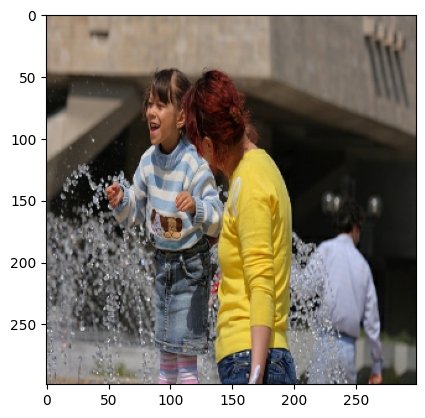

Predicted Caption:  एउटी जवान केटी फोहराको छेउमा उभिरहेकी छिन् जबकि एउटी महिला उनको छेउमा उभिरहेकी छिन्


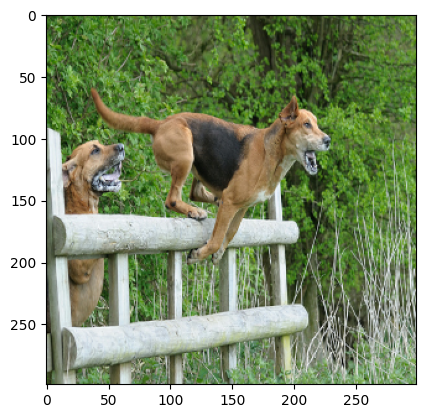

Predicted Caption:  एउटा कुकुर बारमा उफ्रन्छ


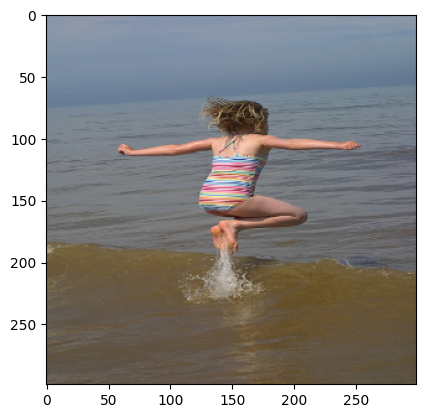

Predicted Caption:  धारीदार स्विमसुट लगाएकी एउटी केटी [UNK]  हाम हाम पौडी हाम पौडी हाम छिन् छिन् हिंडिरहेकी छिन् छ समुद्रमा


In [ ]:
# caption generation
txt_vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(txt_vocab)), txt_vocab))
max_decoded_sent_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())
print(max_decoded_sent_length)
def generate_caption():
    # select random image from validation set
    sample_img = np.random.choice(valid_images)

    # read image
    sample_img = img_data(sample_img)
    #sample_img = img_data('/content/s.jpeg')
    image = sample_img.numpy().astype(np.uint8)
    plt.imshow(image)
    plt.show()

    # pass image to CNN
    image = tf.expand_dims(sample_img,0)
    image = caption_model.cnn_model(image)

    # pass image features to the transformer encoder
    encoded_image = caption_model.encoder(image, training=False)

    # generate caption using transformer decoder
    decoded_caption = "start"
    for i in range(max_decoded_sent_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption,0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_image, training=False, mask=mask
            )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "end":
            break
        decoded_caption += " " + sampled_token

    print("Predicted Caption: ", end=" ")
    print(decoded_caption.replace("start","").replace("end","").strip())

#check predictions
generate_caption()
generate_caption()
generate_caption()

In [ ]:
# Evaluate Model

def get_caption(img_id, caption_model, vectorization, index_lookup, max_decoded_sent_length):

    # read image
    sample_img = img_data(img_id)
    image = sample_img.numpy().astype(np.uint8)

    # pass image to CNN
    image = tf.expand_dims(sample_img,0)
    image = caption_model.cnn_model(image)

    # pass image features to the transformer encoder
    encoded_image = caption_model.encoder(image, training=False)

    # generate caption using transformer decoder
    decoded_caption = "start"
    for i in range(max_decoded_sent_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption,0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_image, training=False, mask=mask
            )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "end":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace('start','').replace('end','').strip()
    #print("Predicted Caption: ", end=" ")
    #print(decoded_caption)
    return decoded_caption

In [ ]:
# Calculate BLEU
def calculate_bleu(cap_map, caption_model, vectorization, index_lookup, max_decoded_sent_length):
    actual_caption, predicted_caption = list(), list()

    # loop over all test data
    for key, cap_list in cap_map.items():
        # generate caption
        generated_caption = get_caption(key, caption_model,vectorization, index_lookup, max_decoded_sent_length)

        # store actual and predicted
        references = [c.split() for c in cap_list]
        actual_caption.append(references)
        predicted_caption.append(generated_caption.split())

    #print(actual_caption)
    #print(predicted_caption)
    print(len(actual_caption))
    print(len(predicted_caption))

    # calculate BLEU
    bleu_1 = corpus_bleu(actual_caption, predicted_caption, weights=(1.0,0,0,0))
    bleu_2 = corpus_bleu(actual_caption, predicted_caption, weights=(0.5,0.5,0,0))
    bleu_3 = corpus_bleu(actual_caption, predicted_caption, weights=(0.33,0.33,0.33,0))
    bleu_4 = corpus_bleu(actual_caption, predicted_caption, weights=(0.25,0.25,0.25,0.25))

    # Print scores
    print('BLEU-1: %f' % bleu_1)
    print('BLEU-2: %f' % bleu_2)
    print('BLEU-3: %f' % bleu_3)
    print('BLEU-4: %f' % bleu_4)

In [ ]:
# remove start and end tokens
def remove_start_end_tokens(cap_map):
    for key, value in cap_map.items():
        for i in range(len(value)):
            value[i] = value[i].replace('start ','').replace(' end','')

    cap_map[key] = value
    return cap_map

In [ ]:
# Remove tokens
eval_data = remove_start_end_tokens(test_data)
#print(eval_data)
print(len(eval_data))

In [ ]:
# 30 epochs_128 batch size - effnet - test data
calculate_bleu(eval_data, caption_model, vectorization, index_lookup, max_decoded_sent_length)

1000
1000
BLEU-1: 0.489562
BLEU-2: 0.364261
BLEU-3: 0.293766
BLEU-4: 0.239828


In [ ]:
''' Try with different epochs'''